# Train an scVI model using Census (SOMA) Pytorch Loaders

This notebook demonstrates how to train an scVI model on Census data using the out-of-core Census (SOMA) PyTorch loaders.

The scvi-tools library is built around Pytorch Lightning, which is a high-level interface for PyTorch that makes it easier to train models. We provide a `CensusSCVIDataModel` class that can be used to feed an ExperimentDataPipe directly into a datamodule class supported by scvi-tools. 

## Contents

1. [Training the model](#training-the-model)
2. [Generate cell embeddings](#generate-cell-embeddings)
3. [Analyzing the results](#analyzing-the-results)

⚠️ Note that the Census RNA data includes duplicate cells present across multiple datasets. Duplicate cells can be filtered in or out using the cell metadata variable is_primary_data which is described in the Census schema.

## Training the model 

We'll now prepare the necessary parameters for running a training pass of the model.

For this notebook, we'll use the stable version of the Census:

In [1]:
import cellxgene_census
import tiledbsoma as soma

census = cellxgene_census.open_soma(census_version="stable")

The "stable" release is currently 2023-12-15. Specify 'census_version="2023-12-15"' in future calls to open_soma() to ensure data consistency.


We'll also do two types of filtering.

For **cells**, we will apply a filter to only select primary cells, with at least 300 expressed genes (nnz >= 300). Specifically for this notebook, we will also apply a tissue filtering so that the training can happen on a laptop. The PyTorch loaders have been designed to work with constant memory, so the same notebook can be run without tissue filtering on a small machine with more time (a GPU is recommended, though). 

For **genes**, we will apply a filter so that only the top 8000 highly variable genes are included in the training. This is a commonly used dimensionality reduction approach and is recommended on production models as well.

Let's define a few parameters:

In [2]:
experiment_name = "mus_musculus"
obs_value_filter = 'is_primary_data == True and tissue_general in ["spleen", "kidney"] and nnz >= 300'
top_n_hvg = 8000
hvg_batch = ["assay", "suspension_type"]

For HVG, we can use the `highly_variable_genes` function provided in the Census, which can compute HVGs in constant memory:

In [3]:
from cellxgene_census.experimental.pp import highly_variable_genes

query = census["census_data"][experiment_name].axis_query(
    measurement_name="RNA", obs_query=soma.AxisQuery(value_filter=obs_value_filter)
)
hvgs_df = highly_variable_genes(query, n_top_genes=top_n_hvg, batch_key=hvg_batch)

hv = hvgs_df.highly_variable
hv_idx = hv[hv].index

We can now create an instance of the CensusSCVIDataModule. 

Since SCVI is a batch correcting model, we need to specify the batch keys for the experiment: in this case, we'll use `dataset_id`, `assay`, `suspension_type`, `donor_id`. The loader will concatenate those keys and produce a unified batch column that will be used for training.

In [4]:
from cellxgene_census.experimental.ml.datamodule import CensusSCVIDataModule

datamodule = CensusSCVIDataModule(
    census["census_data"][experiment_name],
    measurement_name="RNA",
    X_name="raw",
    obs_query=soma.AxisQuery(value_filter=obs_value_filter),
    var_query=soma.AxisQuery(coords=(list(hv_idx),)),
    batch_size=1024,
    shuffle=True,
    batch_keys=["dataset_id", "assay", "suspension_type", "donor_id"],
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)

/opt/cellxgene-census/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Most parameters specified to `CensusSCVIDataModule` will be passed to the `ExperimentDataPipe` class, so you can look at the documentation to understand how it can be tuned. 

In particular, here are some parameters of interest:

* `shuffle`: enables shuffling data. For performance reason, we implemented an algorithm that provides a reasonable approximation of uniform shuffling. This is controlled by the `soma_chunk_size` and `shuffle_chunk_count` parameters.
* TODO: more parameters?

We will now create the SCVI model object:

In [5]:
import scvi

n_layers = 1
n_latent = 50

model = scvi.model.SCVI(n_layers=n_layers, n_latent=n_latent, gene_likelihood="nb", encode_covariates=False)

/var/folders/5p/gtl_p3v92dg2tv2qsy0m8n6c0000gq/T/ipykernel_66169/3003926658.py:6: UserWarning: Model was initialized without `adata`. The module will be initialized when calling `train`. This behavior is experimental and may change in the future.
  model = scvi.model.SCVI(n_layers=n_layers, n_latent=n_latent, gene_likelihood="nb", encode_covariates=False)


Then, we can invoke the `.train` method which will start the training loop. 

For this notebook, we'll only do a single epoch, but this should likely be increased. The SCVI models hosted in CELLxGENE have been trained for 100 epochs.

In [6]:
batch_size = 1024
train_size = 0.9
max_epochs = 1

model.train(
    datamodule=datamodule,
    max_epochs=max_epochs,
    batch_size=batch_size,
    train_size=train_size,
    early_stopping=False,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/cellxgene-census/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/opt/cellxgene-census/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/cellxgene-census/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Epoch 1/1:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/cellxgene-census/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1024. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/opt/cellxgene-census/venv/lib/python3.10/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 903. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 1/1: 100%|██████████| 1/1 [01:51<00:00, 111.59s/it, v_num=1, train_loss_step=2.39e+3, train_loss_epoch=2.94e+3]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 1/1: 100%|██████████| 1/1 [01:51<00:00, 111.60s/it, v_num=1, train_loss_step=2.39e+3, train_loss_epoch=2.94e+3]


We can now save the trained model. As of the current writing date (June 2024), scvi-tools doesn't support saving a model that wasn't generated through an AnnData loader, so we'll use some custom code:

In [7]:
model_state_dict = model.module.state_dict()
var_names = hv_idx.to_numpy()
user_attributes = model._get_user_attributes()
user_attributes = {a[0]: a[1] for a in user_attributes if a[0][-1] == "_"}

user_attributes.update(
    {
        "n_batch": datamodule.n_batch,
        "n_extra_categorical_covs": 0,
        "n_extra_continuous_covs": 0,
        "n_labels": 1,
        "n_vars": datamodule.n_vars,
    }
)

import torch

with open("model.pt", "wb") as f:
    torch.save(
        {
            "model_state_dict": model_state_dict,
            "var_names": var_names,
            "attr_dict": user_attributes,
        },
        f,
    )

We will now load the model back and use it to generate cell embeddings (the latent space), which can then be used for further analysis.

Note that we still need to use some custom code for loading the model, which includes loading the parameters from the `attr_dict` node stored in the model.


In [8]:
with open("model.pt", "rb") as f:
    torch_model = torch.load(f)

    adict = torch_model["attr_dict"]
    params = adict["init_params_"]["non_kwargs"]

    n_batch = adict["n_batch"]
    n_extra_categorical_covs = adict["n_extra_categorical_covs"]
    n_extra_continuous_covs = adict["n_extra_continuous_covs"]
    n_labels = adict["n_labels"]
    n_vars = adict["n_vars"]

    latent_distribution = params["latent_distribution"]
    dispersion = params["dispersion"]
    n_hidden = params["n_hidden"]
    dropout_rate = params["dropout_rate"]
    gene_likelihood = params["gene_likelihood"]

    model = scvi.model.SCVI(
        n_layers=params["n_layers"],
        n_latent=params["n_latent"],
        gene_likelihood=params["gene_likelihood"],
        encode_covariates=False,
    )

    module = model._module_cls(
        n_input=n_vars,
        n_batch=n_batch,
        n_labels=n_labels,
        n_continuous_cov=n_extra_continuous_covs,
        n_cats_per_cov=None,
        n_hidden=n_hidden,
        n_latent=n_latent,
        n_layers=n_layers,
        dropout_rate=dropout_rate,
        dispersion=dispersion,
        gene_likelihood=gene_likelihood,
        latent_distribution=latent_distribution,
    )
    model.module = module

    model.module.load_state_dict(torch_model["model_state_dict"])

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model.to_device(device)
    model.module.eval()
    model.is_trained = True

/var/folders/5p/gtl_p3v92dg2tv2qsy0m8n6c0000gq/T/ipykernel_66169/1280826514.py:19: UserWarning: Model was initialized without `adata`. The module will be initialized when calling `train`. This behavior is experimental and may change in the future.
  model = scvi.model.SCVI(


## Generate cell embeddings

We will now generate the cell embeddings for this model, using the `get_latent_representation` function available in scvi-tools. 

We can use another instance of the `ExperimentDataPipe` for the forward pass, so we don't need to load the whole dataset in memory. 

Note that, at least for now, `shuffle` must be False and parallelism needs to be disabled, otherwise we won't be able to access the `soma_joinids` in the correct order.

In [9]:
# Needs to have shuffle=False for inference
datamodule_inference = CensusSCVIDataModule(
    census["census_data"][experiment_name],
    measurement_name="RNA",
    X_name="raw",
    obs_query=soma.AxisQuery(value_filter=obs_value_filter),
    var_query=soma.AxisQuery(coords=(list(hv_idx),)),
    batch_size=1024,
    shuffle=False,
    soma_chunk_size=50_000,
    batch_keys=["dataset_id", "assay", "suspension_type", "donor_id"],
    dataloader_kwargs={"num_workers": 0, "persistent_workers": False},
)

We can simply feed the datapipe to `get_latent_representation` to obtain the embeddings.

In [10]:
from cellxgene_census.experimental.ml import experiment_dataloader

datapipe = datamodule_inference.datapipe
dataloader = experiment_dataloader(datapipe, num_workers=0, persistent_workers=False)
mapped_dataloader = (datamodule_inference.on_before_batch_transfer(tensor, None) for tensor in dataloader)
latent = model.get_latent_representation(dataloader=mapped_dataloader)

emb_idx = datapipe._obs_joinids

We successfully trained the model and generated embeddings using constant memory. Even on the full Census, this has been tested to run with less than 30G of memory (using a single worker).

## Analyzing the results

We will now take a look at the UMAP for the generated embedding. Note that this model was only trained for one epoch (for demo purposes), so we don't expect the UMAP to show significant integration patterns, but it is nonetheless a good way to check the overall health of the generated embedding.

In order to do this, we'll use `scanpy` which accepts an AnnData object, so we'll generate one using the `get_anndata` utility function:

In [11]:
adata = cellxgene_census.get_anndata(
    census,
    organism=experiment_name,
    obs_value_filter=obs_value_filter,
)

In order for `scanpy` to generate the neighbors graph, we need to add the generated embedding (stored in `latent`) in the obsm slot of the AnnData object:

In [12]:
obs_soma_joinids = adata.obs["soma_joinid"]

import pandas as pd

obs_indexer = pd.Index(emb_idx)
idx = obs_indexer.get_indexer(obs_soma_joinids)
# Reindexing is necessary to ensure that the cells in the embedding match the ones in the anndata object.
adata.obsm["scvi"] = latent[idx]

We can now generate the neighbors and the UMAP.

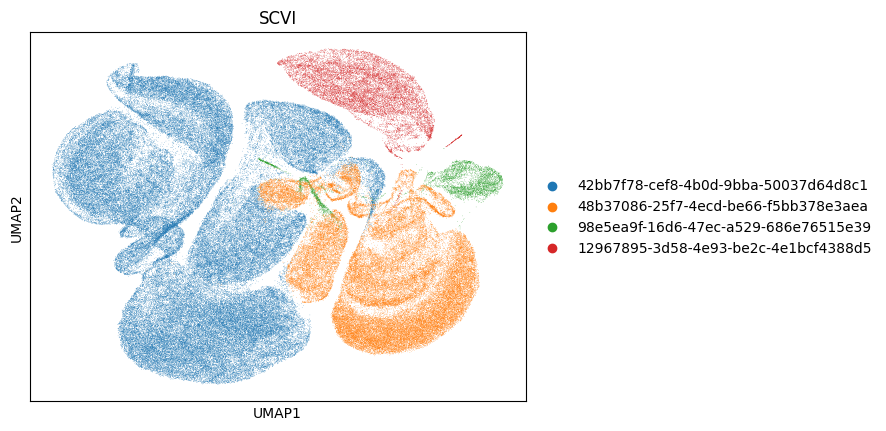

In [13]:
import scanpy as sc

sc.pp.neighbors(adata, use_rep="scvi", key_added="scvi")
sc.tl.umap(adata, neighbors_key="scvi")
sc.pl.umap(adata, color="dataset_id", title="SCVI")